# Workshop med BRAIN NTNU

Vi har sett hva *attention* er og hvordan det brukes for å bygge nevrale nettverk. Tenk på attention som en byggeblokk som brukes for å lage en modell. Det er mulig å kombinere denne blokken med andre typer mekanismer, for eksempel *convolutions* eller *fully connected layers*. *Transformers* er en type modell som baserer seg på attention, og har oppnådd stor suksess.


Vi i Oda bruker attention i flere av våre anbefalingsmodeller, og to av disse skal vi nå bruke til å lage en prototype.

## Attention modeller i Oda
Den første modellen kaller vi **Likely to Buy** (L2B). Som navnet tilsier prøver denne modellen å predikere hva hver kunde er mest sannslig til å kjøpe i sin neste ordre. Modellen tar inn ordrehistorikken, data om brukeren og data om produktene. Den gir en score for hvert product tilhørende en bruker. Så sorterer man på denne scoren til å få en rangert liste av relevante produkter. Produkter en bruker kjøper ofte, f.eks. melk, brød og frukt, vil havne høyt oppe på denne listen. Modellen er designet slik at handlingen blir mest mulig effektiv for brukeren. Modellen gir prediksjoner hvert døgn over natten slik at den bruker den siste relevante dataen. L2B gir også en predikert sannsynlighet for produkter brukeren ikke har kjøpt før.


Den andre vi skal bruke er laget for en applikasjon som heter **Build Your Own Dinner** (BYOD). Her er treningsdataen bestående av middagsprodukter. Brukern kan lage en middagsliste, og modellen anbefale produkter som passer med det som allerede ligger i listen. Brukeren interagerer med modellen live. Modellen tar inn en liste med produkter og gir tilbake en liste med relaterte produkter. For eksempel, hvis jeg starter med å legge til tacokrydder vil modellen anbefale lefser, tortillas, avokado osv. Ved at brukeren interagerer med prediksjonene får vi også samlet verdifull data.

## Dagens prototype: Bundle builder

BYOD er en stegvis prosess der brukeren jobber sammen med modellen for å lage en middagsliste. For hvert steg gir modellen forslag av produkter og brukeren vil basert på preferanser ta et valg over hva som skal være med i listen. Intensjonen er at det skal være interaktivt, både fordi det skal være en god brukeropplevelse, men også for at vi skal kunne samle data. For hva er egentlig en middag? Hvilke og hvor mange produkter inngår i en middag? Min taco er mest sannsynligvis annerledes en din taco. Noen bruker First Price spice mix, andre Old El Paso. Noen lager sin egen salsa, andre kjøper salsa på glass. Hver middag består av et sett med produkter der hver bruker har egne preferanser. 


I stedet for å la brukeren ta valget, skal vi nå bruke L2B modellen. Hypotesen er at L2B modellen er god nok til å reflektere brukerens preferanser. Dermed kan vi simulere prosessen der vi bruker de to modellene sammen til å lage en middagsliste. For hvert steg vil BYOD modellen gi en liste av relevante produkter (kandidater). Ved å bruke L2B modellen kan vi rangere denne listen og velge produktet som inngår i middagslisten. Den oppdaterte middagslisten gang deretter mates til BYOD modellen som på nytt vil gi en liste med relevante produkter. Dette er illustrert i figuren under. 

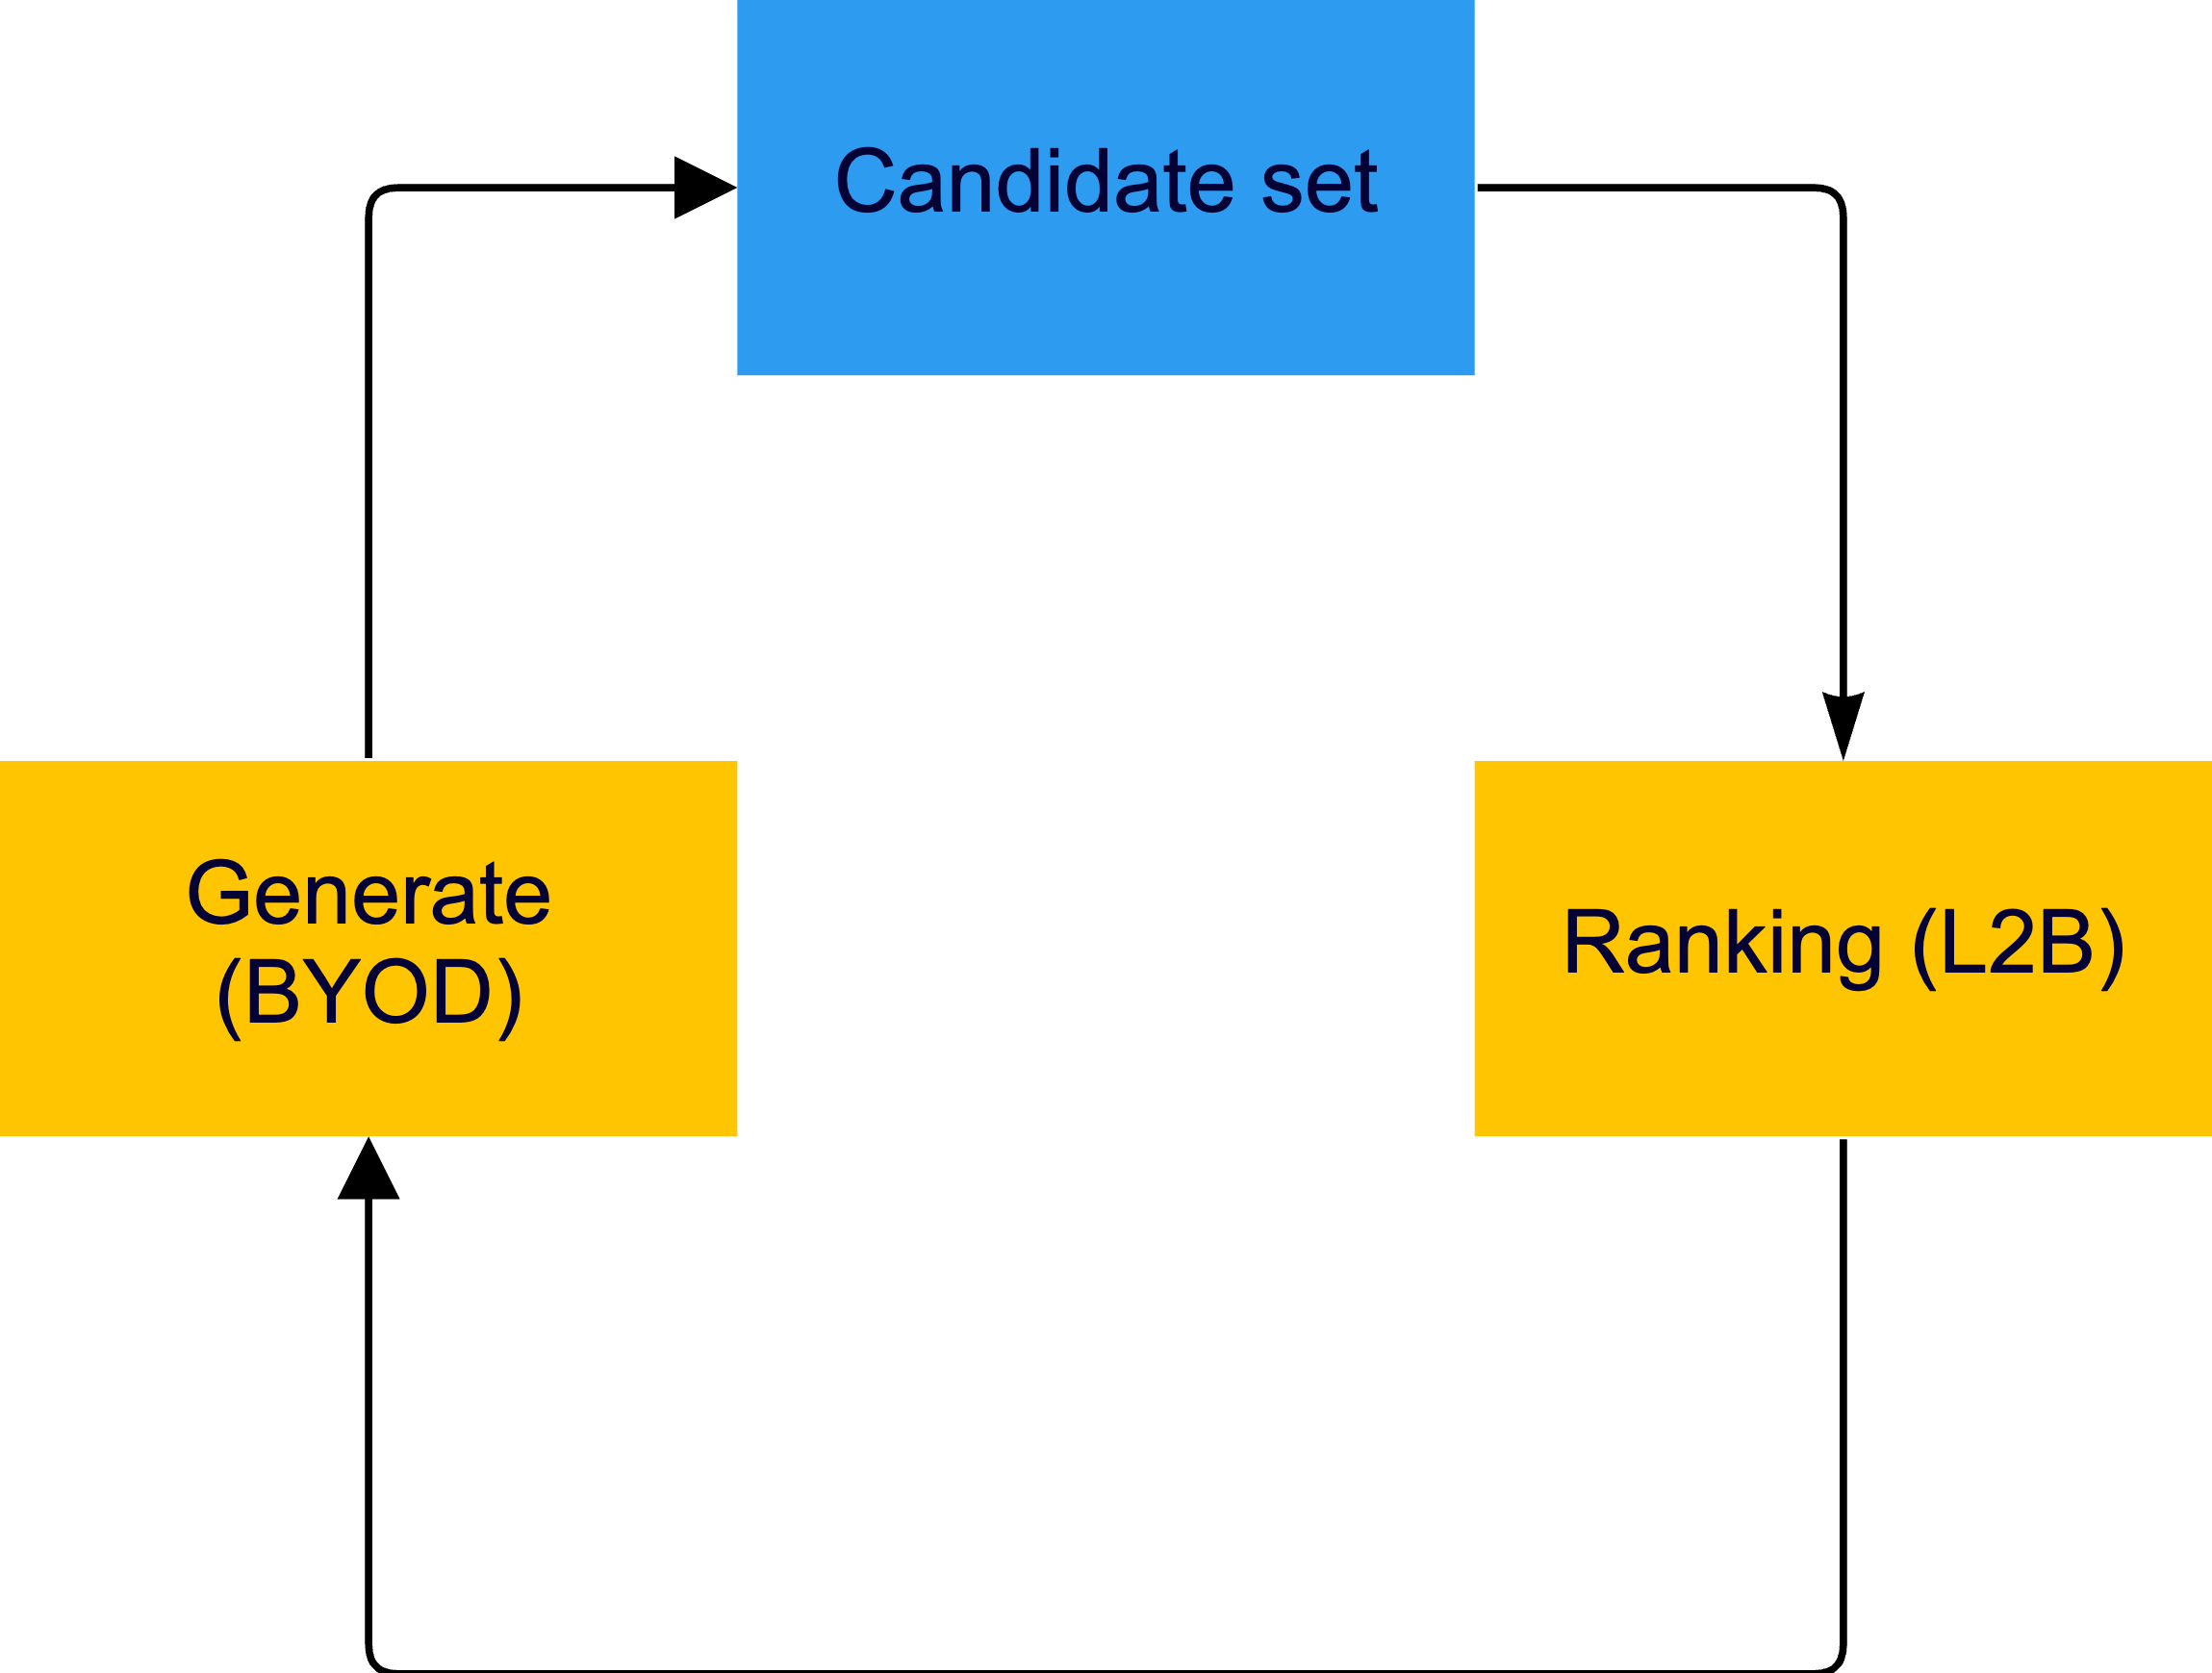

I denne loopen må vi også ta stilling til hvordan man skal starte og stoppe. BYOD modellen må ta inn minst ett product for å fungere. Vi definerer derfor flere forskjellige middager der hver middag har en liste med "seeds". Ta eksempelet med taco som er en av de middagene som er definert. Vi ønsker å starte med produkterer som er unikt for taco slik at resten av loopen holder seg innenfor taco-relaterte produkter. Agurk kan brukes i veldig mange middagsretter, inkludert taco. Derfor vil det ikke gi mening å starte med agurk. Vi kan derimot bruke produkter som spice mix og salsa. 

Vi må også ha kriterie for å stoppe loopen. Når er en middag komplett? En enkel fremgangsmåte er å bare bruke antall produkter, men det er mulig å tenke på andre kriterier også.


Vi ønsker også at produktene i middagslisten skal være forskjellige. Det nytter ikke med to forskjellige typer pasta. Vi kan derfor legge inn dette som et en prosedyre i loopen. 


En skisse av algoritmen ser dermed slik ut: 


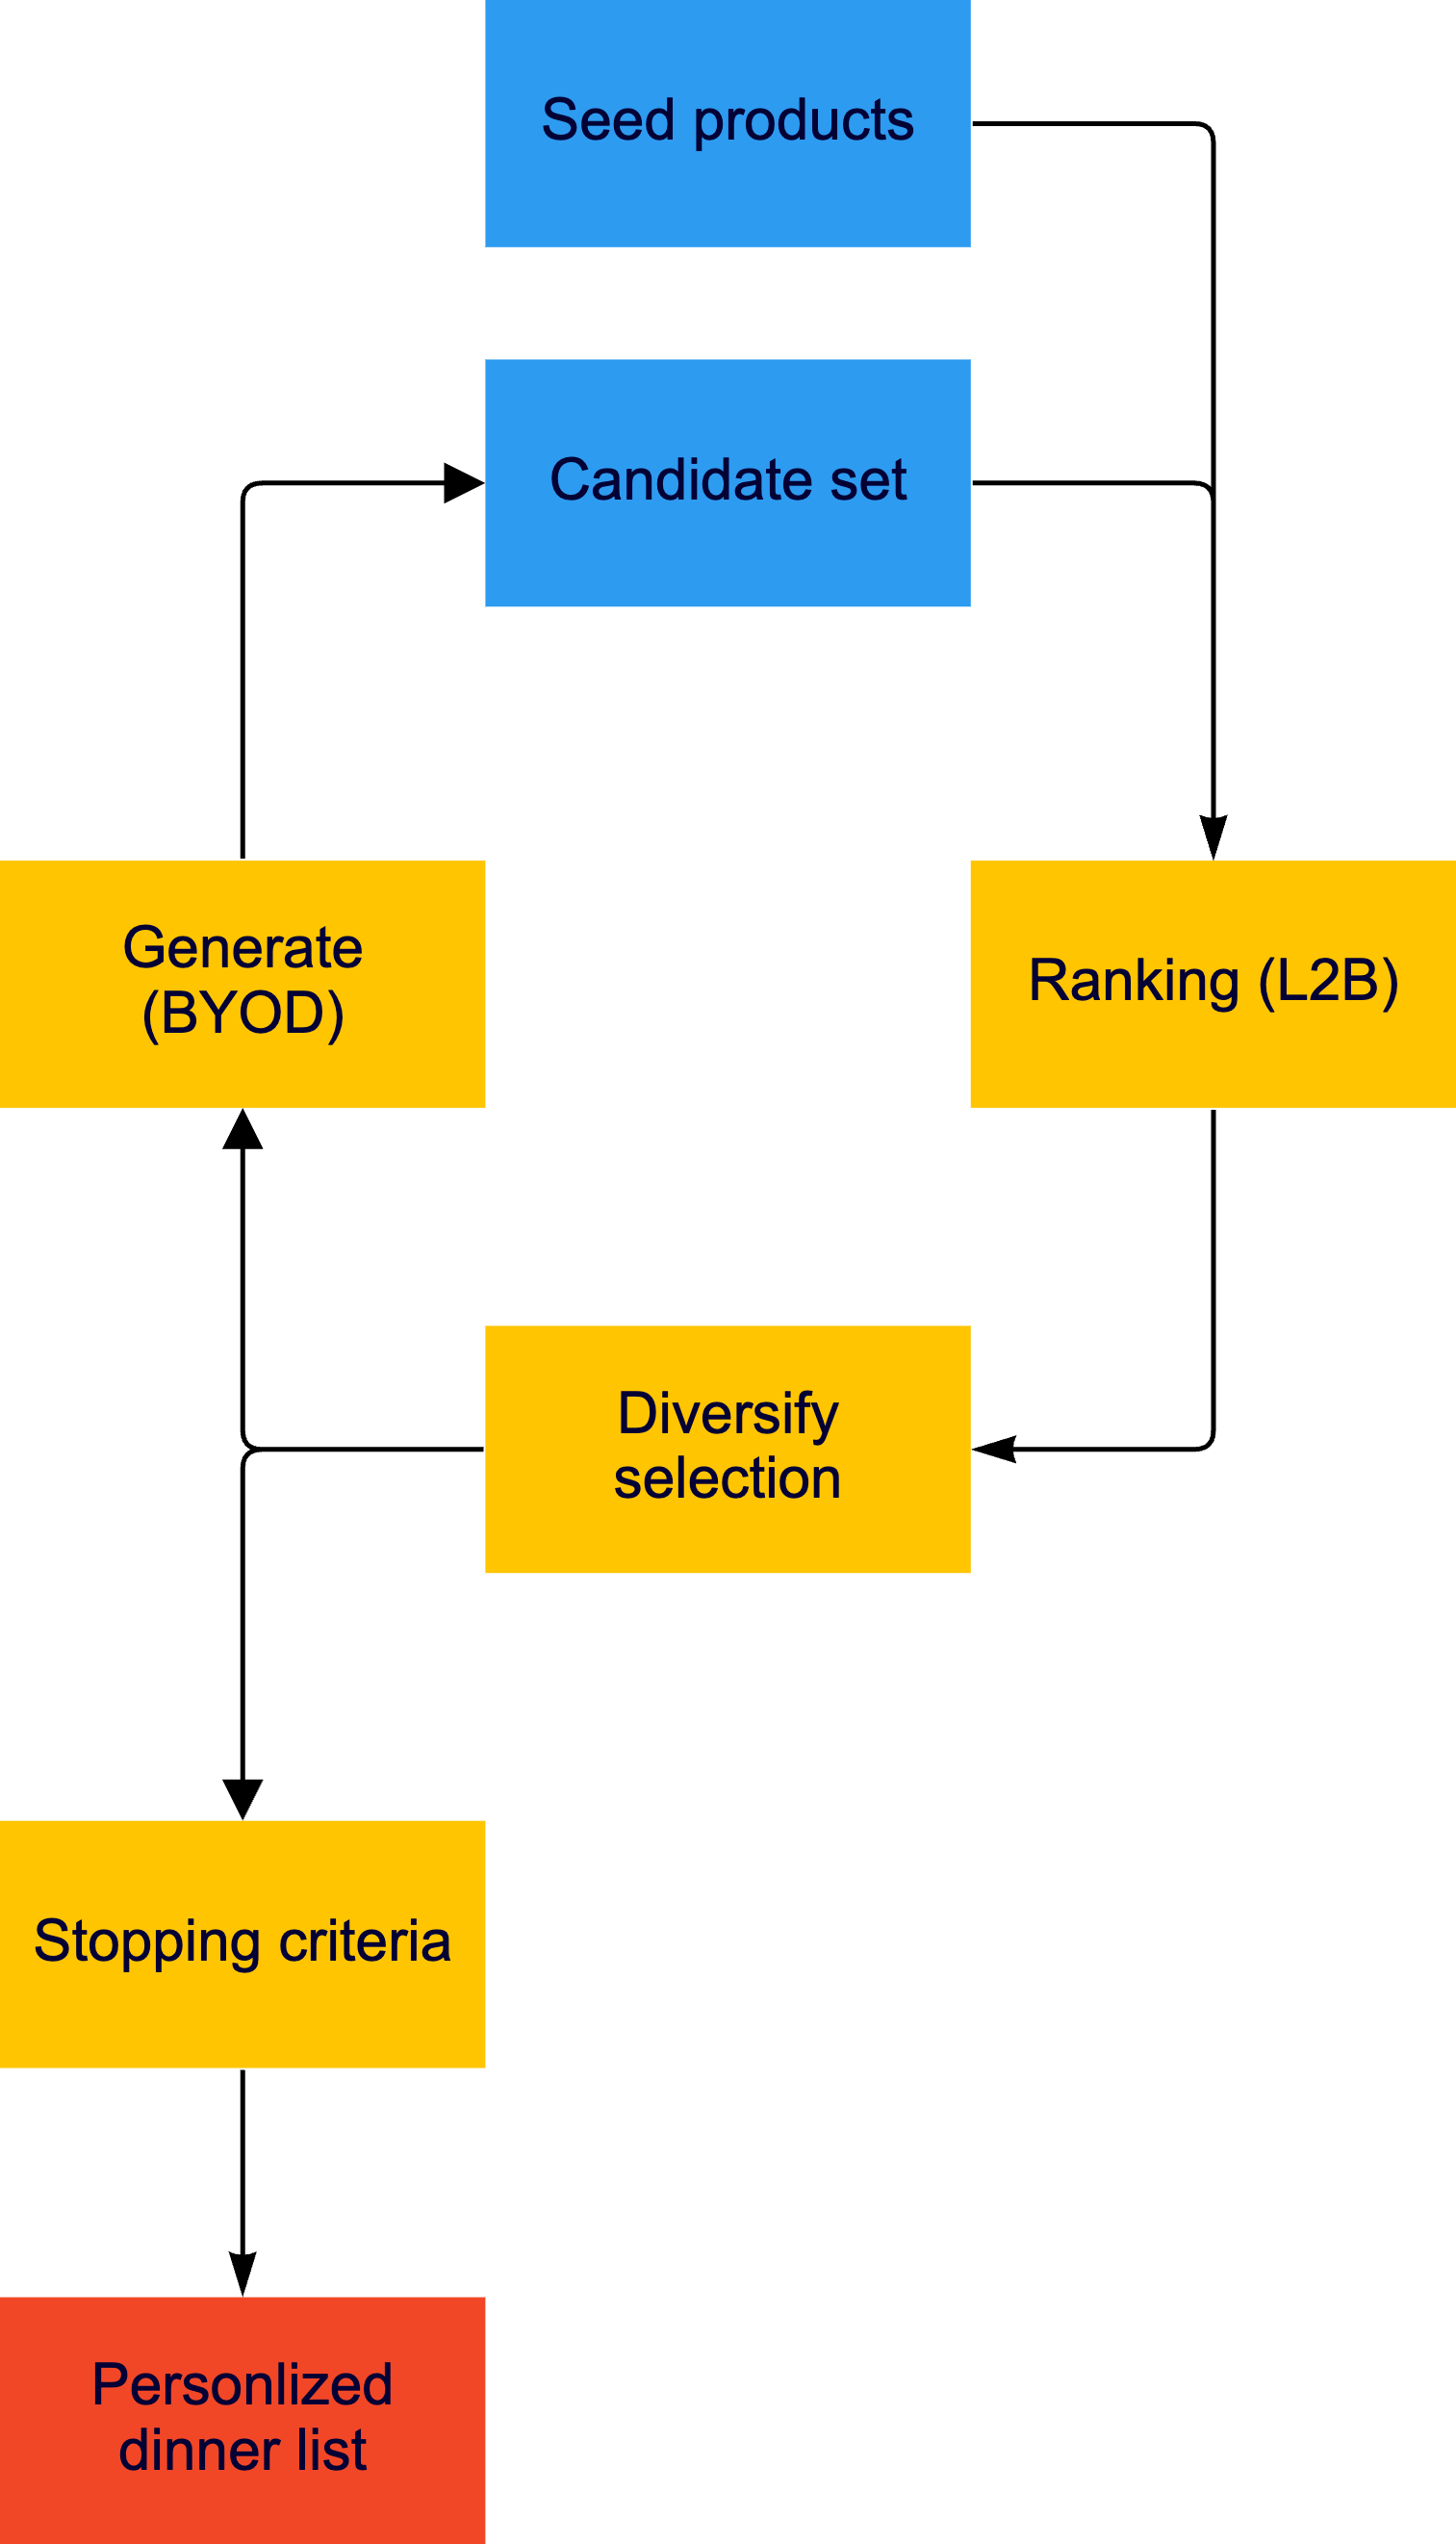


In [ ]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from typing import Tuple
from applications.dinner_builder.bundles import get_predictions, load_model, get_bundle_products, get_bundles_for_all_users
from applications.dinner_builder.utils import (
    create_id_to_idx_mapping,
    create_id_to_name_mapping,
    create_idx_to_name_mapping,
    create_idx_to_category_two_mapping,
    create_idx_to_id_mapping,
)
from base_models.product_set_model.models.transformer.utils import (
    predict_next,
)
from fabrica_common.settings import GCP_BUCKET, GCP_PROJECT

## Laste inn input
Vi starter med å laste inn det vi trenger inn i notebooken. Det vi trenger er:
- Prediksjoner fra L2B.
- BYOD modell. 
- "Seed produkter"

Vi begynner med L2B prediksjoner. Her trenger vi ikke selve modellen siden vi klarer oss med kun prediksjonene. Vanligvis vil modellen gi prediksjoner hver natt som da blir vist til brukeren. 

For å gjøre treningen av modellen lettere, har vi kun brukt 3000 av de mest populære produktene i treningen. Hvert produkt har en *product_id*. Denne id i seg selv er kun et arbitrært tall. Under treningen blir denne "mapped" til in indeks mellom 1 og 3000. 

Prediksjonene kommer i en dictionary der innholder er:
- `input_product_id`, dette er product id-ene.
- `input_product_index`, dette er tilhørende index mellom 1 og 3000. 
- `user`, dette er id-en til brukeren.
- `scores`, dette er predikert score fra modellen. Legg merke til at det ikke er sortert enda. 

In [ ]:
artifacts_folder = Path("artifacts/")
prediction_folder = artifacts_folder / "predictions"
seed_folder = artifacts_folder / "seeds"
predictions_location = Path(
    "projects/vvtdt_recommender/2.0.0/Norway/predictions/RecAttentionModel/"
)
initial_dinner_location = Path(
    "projects/base_models/applications/dinner_builder/dinner_dictionary.json"
)

In [ ]:
print("Loading predictions...")
preds = get_predictions(prediction_folder, GCP_BUCKET, predictions_location)
predictions_smaller = dict(preds)
users = np.array([696899, 304793, 891991, 706, 9, 5515])
mask = np.isin(predictions_smaller["user"], users)
predictions_smaller["user"] = predictions_smaller["user"][mask]
predictions_smaller["scores"] = predictions_smaller["scores"][mask]

Neste er BYOD modellen. Her trenger vi selve modellen siden vi skal bruke den i algoritmen. Det er en modell skrevet i Tensorflow. 

In [ ]:
print("Loading model...")
byod_model = load_model("transformer_N10")

Sist ut er det vi kaller "seeds". Vi har på forhånd definert noen vanlige middager, som f.eks. taco, pasta og pizza. I algoritme vi har beskrevet, trenger vi et sted å starte. En enkel måte å gjøre det på er å starte med en kuratert liste med produkter for hver middag. Vi må da tenke på hva som er gode startpunkt, eller seeds. For eksempel, vi kunne starte med agurk i en tacomiddag. Men agurk kan brukes i mange forskjellige typer middag, og modellen vil da slite med å identifisere taco. Et bedre startpunkt er tacokrydder eller salsa. Dette er produkter som er relativt unikt for en tacomiddag, og modellen vi da ha en bedre forutsetning for å lykkes. Vi har manuelt definert en liste med produkter for hver middag. 

Denne fremgangsmåten er relativt enkel, og har sine begrensninger. Kan du se hvilke? Og hvilke andre måter kunne man gjort dette på?

In [ ]:
bundle_seeds = get_bundle_products(
    local_path=seed_folder,
    bucket=GCP_BUCKET,
    bucket_location=initial_dinner_location,
)

Her ser vi hvilke middager som er definert. For hver middag, har vi en liste med product id-er. 

In [ ]:
bundle_seeds.keys()

In [ ]:
bundle_seeds["taco"]

# Mappings
Vi har to modeller som er trent på to forskjellige sett med produkter. L2B er trent på 3000 populære produkter, mens BYOD er trent på middagsprodukter. Hver av modellene bruker indekser i treningen, og ikke id-er direkte. Vi må derfor definere mapping-funksjoner mellom id og index. Her gjør vi det for BYOD.

In [ ]:
id_to_name_mapping = create_id_to_name_mapping()
idx_to_name_mapping = create_idx_to_name_mapping()
idx_to_id_mapping = create_idx_to_id_mapping()
id_to_idx_mapping = create_id_to_idx_mapping()

## L2B rangering

La oss først se på hvordan vi kan rangere en liste med produkter ved hjelp av L2B modellen. Vi må da gjøre to ting:
- Først filtrere på hvilke produkter vi ønsker å se på. 
- Så må vi sortere på score. 

In [ ]:
taco_seeds = bundle_seeds["taco"]
l2b_product_ids = predictions_smaller["input_product_id"]
test_scores = predictions_smaller["scores"][2]

# filter out taco products not that are not l2b products
indicators_products = np.isin(taco_seeds, l2b_product_ids)
taco_filtered = np.array(taco_seeds)[indicators_products]

# filter scores by the taco products that are left
indicators_scores = np.isin(l2b_product_ids, taco_filtered)
scores_filtered = test_scores[indicators_scores]

# sort scores and product ids
idx_sorted = np.argsort(-scores_filtered).astype(np.int16)
product_ids_sorted = taco_filtered[idx_sorted]
scores_sorted = scores_filtered[idx_sorted]

In [ ]:
# map to names to inspect results
names_sorted = [id_to_name_mapping[id] for id in product_ids_sorted]
print(*names_sorted, sep='\n')

Vi samler alt dette i en funksjon som vi kan bruke senere. 

In [ ]:
def rank_candidates(
    scores: list, product_ids: list, candidates: list
) -> Tuple[list, list]:
    """
    Rank a list of candidates by L2B scores.

    Args:
        scores (list): L2B output scores.
        product_ids (list): L2B product ids.
        candidates (list): List of product ids to be ranked.

    Returns:
        Tuple[list, list]: ranked list and corresponding scores.
    """
    # filter candidates products by l2b products
    indicators_products = np.isin(candidates, product_ids)
    candidates_filtered = np.array(candidates)[indicators_products]

    # filter scores by candidate products
    indicators_scores = np.isin(product_ids, candidates_filtered)
    scores_filtered = scores[indicators_scores]

    if len(candidates_filtered) == 1:
        return candidates_filtered, scores_filtered

    if len(candidates_filtered) == 0:
        return [candidates.pop(0)], [scores.min()]

    idx_sorted = np.argsort(-scores_filtered).astype(np.int16)
    product_ids_sorted = candidates_filtered[idx_sorted]
    scores_sorted = scores_filtered[idx_sorted]
    return product_ids_sorted, scores_sorted

## BYOD kandidater

La oss så se på hvordan BYOD modellen virker i praksis. Modellen tar inn en liste med produkter, og vil gi ut produkter som passer godt overens. Vi bruker funksjonen `predict_next`, der input er modellen, input produkter og hvor mange produkter som skal returneres. Husk at her må vi mappe produkt id til indeks for at modellen skal fungere. Funksjonen vil også gi en score for hvert produkt.

Vi fortsetter med eksempelet med taco. Vi kan da ta det første produktet i den rangerte listen, og generere nye produkter. 

In [ ]:
# select highest rated product
selected_product_id = product_ids_sorted[0]
# map ti idx
selected_product_idx = id_to_idx_mapping[selected_product_id]
# generate new products
candidates_idx, byod_score = predict_next(byod_model, [selected_product_idx], k=10)
candidates_names = [idx_to_name_mapping[idx] for idx in candidates_idx]
print(*candidates_names, sep="\n")

Vi kan nå tenke oss at vi tar disse produktene og rangerer de med L2B modellen.

In [ ]:
candidates_id = [idx_to_id_mapping[idx] for idx in candidates_idx]
candidates_ranked, _ = rank_candidates(test_scores, l2b_product_ids, candidates_id)
candidates_ranked_names = [id_to_name_mapping[id] for id in candidates_ranked]
print(*candidates_ranked_names, sep="\n")

Vi kunne nå valgt det beste produktet på nytt, for å så generere nye produkter. Da vil vi ha gjennomført den første iterasjonen av algoritmen vår.


## Første utkast

Vi kan nå skrive dette som en while-loop. Vi trenger å spesifisere når loopen skal avsluttes og middagen er servert. Her gjør vi det enkelt med å bruke antall produkter, men kan du tenke på andre måter å gjøre dette?

In [ ]:
bundle_idxs = []
candidates = taco_seeds
max_bundle_length = 10
n_byod_products = 10 

while len(bundle_idxs) < max_bundle_length:
    # ranking using l2b
    ranked_ids, ranked_scores = rank_candidates(
        scores=test_scores, product_ids=l2b_product_ids, candidates=candidates
    )

    # pick product
    best_product_id = ranked_ids[0]
    best_product_idx = id_to_idx_mapping[best_product_id]
    bundle_idxs.append(best_product_idx)

    # generate new candidates
    candidates_idx, byod_scores = predict_next(
        byod_model, bundle_idxs, k=n_byod_products
    )

    candidates = [idx_to_id_mapping[idx] for idx in candidates_idx]

bundle = [idx_to_id_mapping[idx] for idx in bundle_idxs]

In [ ]:
bundle_names = [id_to_name_mapping[idx] for idx in bundle]
print(*bundle_names, sep="\n")

## Diversify

Vi vil også sørge for at en middags-bundle inneholder inneholder duplikater av ingredienser. For eksempel trenger man som regel ikke flere enn en type salsa for taco. Vi bruker kategorier for dette, og setter et tall for maksimalt antall produkter per kategori. Dette er heller ikke en optimal løsning. Hvorfor ikke? 

I denne funksjonen grupperer vi først alle produktene i kategorier. Så rangerer vi produktene på max score fra BYOD. Deretter velger vi den første kategorien som oppfyller kriteriet vi har satt.

In [ ]:
def diversify_by_category(
    candidates: list,
    used_categories: defaultdict,
    byod_scores: list,
    idx_to_category_mapping: dict,
    max_category_limit: int = 1,
) -> list:
    """
    Diversify the candidate selction based on information of the category of products.

    Args:
        candidates (list): product ids of proposed products.
        used_categories (defaultdict): to keep score of the categories already used.
        byod_scores (list): output scores from the byod model.
        idx_to_category_mapping (dict): mapping to category name.
        max_category_limit (int, optional): Number of products within each category. Defaults to 1.

    Returns:
        list: filtered list of candidates based on category information.
    """
    # group products by categories
    d = defaultdict(list)
    for idx, score in zip(candidates, byod_scores):
        d[idx_to_category_mapping[idx]].append([idx, score])

    # sort by max score within category
    category_sorted = sorted(
        d.items(), key=lambda x: max([i[1] for i in x[1]]), reverse=True
    )

    # pick products from first valid category
    for category, products in category_sorted:
        if used_categories[category] >= max_category_limit:
            continue
        else:
            used_categories[category] += 1
            candidates_filtered = [product[0] for product in products]
            return candidates_filtered, used_categories

    # if none of the categories is valid
    return [], None

## Rank bundles

Vi vil også ha muligheten til å rangere middagene. Funksjonen nedenfor går gjennom alle middagene og rangerer based på gjennomsnittlit L2B-score på produktene. 

In [ ]:
def rank_bundle_for_each_user(bundles_for_all_users: defaultdict) -> defaultdict:
    """
    Rank bundle per user using scores from l2b.

    Args:
        bundles_for_all_users (defaultdict): Containing bundles for all users.

    Returns:
        defaultdict: Same as input, but the bundles are ranked per user.
    """
    for user, bundles in bundles_for_all_users.items():
        bundles_ranked = sorted(
            bundles.items(), key=lambda x: np.mean(x[1]["scores"]), reverse=True
        )
        bundles_for_all_users[user] = bundles_ranked

    return bundles_for_all_users

## Sett alt sammen

Nå har vi definert alle komponentene som brukes i algoritmen, og vi kan sette alt sammen. Først definerer vi en funksjon som itererer over alle middagene og brukere.

In [ ]:
def get_bundles_for_all_users(
    model: tf.keras.Model,
    predictions: dict,
    bundle_seeds: dict,
    max_bundle_length=10,
    max_category_limit=2,
    n_byod_products=30,
) -> dict:
    """
    Composes dinner bundles for all customers.

    Args:
        model (tf.keras.Model): Build Your Own Dinner model.
        predictions (dict): Prediction scores from Likely to Buy model.
        bundle_seeds (dict): Contains product ids for predefined bundles.
        max_bundle_length (int, optional): _description_. Defaults to 10.
        max_category_limit (int, optional): _description_. Defaults to 2.
        n_byod_products (int, optional): _description_. Defaults to 30.

    Returns:
        dict: bundles for all users.
    """
    bundles_for_all_users = defaultdict(dict)
    id_to_idx_mapping = create_id_to_idx_mapping()
    idx_to_id_mapping = create_idx_to_id_mapping()
    id_to_name_mapping = create_id_to_name_mapping()
    idx_to_category_mapping = create_idx_to_category_two_mapping()

    for bundle_name, seed_products in bundle_seeds.items():
        print(f"Making some {bundle_name}...")
        seed_products_filtered = [
            id for id in seed_products if id in id_to_idx_mapping.keys()
        ]
        l2b_ids = predictions["input_product_id"]
        for user, scores in zip(predictions["user"], predictions["scores"]):
            bundle_ids, bundle_scores = create_bundle_for_user(
                model,
                scores,
                l2b_ids,
                seed_products_filtered,
                id_to_idx_mapping,
                idx_to_id_mapping,
                idx_to_category_mapping,
                max_bundle_length,
                max_category_limit,
                n_byod_products,
            )
            bundle_product_names = [id_to_name_mapping[id] for id in bundle_ids]
            bundles_for_all_users[user][bundle_name] = {
                "ids": bundle_ids,
                "names": bundle_product_names,
                "scores": bundle_scores,
            }

    bundles_for_all_users_ranked = rank_bundle_for_each_user(bundles_for_all_users)

    return bundles_for_all_users_ranked

Deretter definerer vi funksjonen som lager middag for en bruker:

In [ ]:
def create_bundle_for_user(
    model: tf.keras.Model,
    scores: list,
    l2b_product_ids: list,
    seed_products: list,
    id_to_idx_mapping: dict,
    idx_to_id_mapping: dict,
    idx_to_category_mapping: dict,
    max_bundle_length: int,
    max_category_limit: int,
    n_byod_products: int,
) -> list:
    """
    Compose the bundle for a single user.

    Args:
        model (tf.keras.Model): BYOD model.
        scores (list): L2B prediction scores.
        l2b_product_ids (list): L2B vocabulary product ids.
        seed_products (list): Seed products for given bundle.
        id_to_idx_mapping (dict): BYOD mapping to idx.
        idx_to_id_mapping (dict): BYOD mapping to id.
        idx_to_category_mapping (dict): BYOD mapping to category.
        max_bundle_length (int, optional): Max number of products of the bundle.
        max_category_limit (int, optional): Max number of products within same category.
        n_byod_products (int, optional): Number of output products of BYOD model.

    Returns:
        list: One bundle for a single user.
    """
    bundle_idxs = []
    l2b_bundle_scores = []
    used_categories = defaultdict(int)
    candidates = seed_products

    while len(bundle_idxs) < max_bundle_length and used_categories is not None:
        # ranking using l2b
        ranked_ids, ranked_scores = rank_candidates(
            scores=scores, product_ids=l2b_product_ids, candidates=candidates
        )

        # pick product
        best_product_id = ranked_ids[0]
        best_product_idx = id_to_idx_mapping[best_product_id]
        bundle_idxs.append(best_product_idx)
        l2b_bundle_scores.append(ranked_scores[0])

        # generate new candidates
        candidates_idx, byod_scores = predict_next(
            model, bundle_idxs, k=n_byod_products
        )

        candidates_filtered, used_categories = diversify_by_category(
            candidates_idx,
            used_categories,
            byod_scores,
            idx_to_category_mapping,
            max_category_limit=max_category_limit,
        )
        candidates = [idx_to_id_mapping[idx] for idx in candidates_filtered]

    bundle = [idx_to_id_mapping[idx] for idx in bundle_idxs]
    return bundle, l2b_bundle_scores


## Visualisering og testing

Vi kan nå teste modellen og se at alt fungerer. Det er tre parametre vi kan spesifisere. 
- `max_bundle_length`: hvor mange produkter skal det være i en middag
- `max_category_limit`: hvor mange produkter per kategori
- `n_byod_products`: hvor mange produkterer som returneres fra BYOD modellen

Her kan du du teste ut forskjellige parametre og se hvordan det påvirker resultatet. 

In [ ]:
bundles_for_all_users = get_bundles_for_all_users(model=byod_model, 
                                                  predictions=predictions_smaller, 
                                                  bundle_seeds=bundle_seeds, 
                                                  max_bundle_length=5, 
                                                  max_category_limit=1, 
                                                  n_byod_output=30)

Funksjonen nedenfor vil visualisere resultatet for en gitt bruker. Her er kolonnene rangert fra venstre til høyre. I tillegg viser fargene scoren fra L2b.

In [ ]:
def print_bundles_for_user(user, bundles_for_all_users):
    user_bundles = pd.DataFrame()
    user_scores = pd.DataFrame()
    bundles = bundles_for_all_users[user]
    for name, data in bundles:
        user_bundles[name] = data["names"]
        user_scores[name] = tf.nn.softmax(data["scores"]).numpy()

    user_bundles = user_bundles.style.background_gradient(axis=None, gmap=user_scores, vmin=0, vmax=1)
    return user_bundles

In [ ]:
user = 5515
print_bundles_for_user(user, bundles_for_all_users)

## Åpne problemer

Vi har nå sett en mulig algoritme for å kombinere to maskinlæringsmodeller for å lage personaliserte middager. Det er derimot flere måter å forbedre algoritmen. Ved å teste for forskjellige brukere og ulike parametre vil du kanskje se ting som ikke gir mening. Kan du tenkte deg noen måter å gjøre det bedre? Test ut noen endringer og se hvordan det blir!


Noen forslag som kan testes:
- **Aggregering av scores**: To ulike steder i koden brukte vi aggregering av scores. Først når vi skulle finne neste kategori. Da brukte vi max av product-score fra byod. Andre gangen var da vi rangerte middagene og brukte mean av product-score fra l2b. Hvilken innvirkning har dette? Test gjerne ut forskjellige måter. 
- **Kombinere L2B og BYOD score i ranking**: scoren fra de to modellene reflekterer to forskjellige ting. L2B-scoren sier noe om hvor godt passer dette produktet sammen med brukeren. BYOD-scoren sier noe om hvor godt et produkt passer sammen med en eksisterende liste av produkter. Når vi gjorde rangering av produktene brukte vi kun L2B score. Som en konsekvens kan man ende opp i en situasjon der L2B "tar over" og velger produkter som egentlig ikke passer så godt. Hvordan kan man kombinere scoren fra begge modellene?
- **Når er en middag ferdig?** Vi har nå brukt antall produkter som kriterium for når vi skal stoppe. Men det er ikke slik at en middag alltid inneholder 10 produkter. Hvordan kan man gjøre dette mer dynamisk?
- **Seed produkter**: Her har vi manuelt kuratert lister med seeds for å starte algoritmen. Denne listen er langt i fra perfekt, og ideelt sett har vi en metode som sier hvilke produkter som er gode startpunkt for hver bruker. Kan du tenke deg måter å gjøre dette på?
- **Andre søkealgoritmer**: Algoritmen vi har implementert er et grådig søk. Basert på de valgene vi har for hvert steg, velger vi det beste basert på en rangering. Men det er ikke sikkert dette er det optimale valget. Hvordan kan man gjøre dette bedre?
- ...

Du kan gjerne prøve å skrive litt kode eller bare tenk over hvordan dette problemet kan løses på en bedre måte. Er det f.eks. mulig å lage en modell som predikerer en bundle? Hvilken rolle har datainnsamling her? Vi tar en oppsummering til slutt for å diskutere det vi har funnet ut.